# **Bias measuring and mitigation in recommendation systems**

The bias problem can appear in models when the predictions systematically deviate from the true values for certain subgroups in the dataset. This phenomenon can occur due to various reasons such as unbalanced groups in the training data, feature selection, or model specification. Because of this, the bias problem can appear in different tasks, being "recommendation systems" one of them. A recommender system aims to recommend the best item according to the user preference.

There are various techniques to measure bias in recommendation systems. One common approach is to use fairness metrics such as aggregate diversity, exposure entropy, or gini index, which are item based metrics that, in general terms, calculate the distribution to observe the proportions of items are shown to the user.

Once bias is detected, we can employ different techniques to mitigate it. These methods can be grouped into three categories: Pre-processing, in-processing and post-processing methods. Pre-processing techniques are used to adjust the training data to remove bias, while in-processing methods are applied to build robust models against bias. Finally, post-processing techniques are used to adjust the model's predictions to remove bias.

A recommender system can be biased in multiple ways. For example, we may be concerned that the artists in our database will not get equal representation (item fairness). Alternative, our main concern may be that different groups of users (e.g. male/female users) will get different music recommendations (user fairness). In the following, we will show how to explore the data for fairness, and measure these various types of fairness using the holisticai library.

Through this tutorial, we pretend to present you tools which can be easily applied to measure and mitigate the presence of bias in recommender systems, focusing on the task of correctly predicting users' music preference.

We will follow the traditional outline for this tutorial:

1. Packages loading and installation
2. Data exploration
3. Model training
4. Bias measuring
5. Bias mitigation
6. Results comparison

## **1. Packages loading and installation**

First of all, we need to import the required packages to perform our bias analysis and mitigation. You will need to have the `holisticai` package installed on your system, remember that you can install it by running: 
```bash
!pip install holisticai[all]
```

In [1]:
# Base Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

## **2. Data exploration**

The dataset that we will use is the "Last FM Dataset" which is a publicly available dataset that contains a set of artists that were downloaded by users. It includes personal information about the user, specifically sex and country of origin. A user can download more than one artist. We will use the column "score", which contains only 1s for counting the interactions.

Source: [GroupLens ](https://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt)

In [3]:
from holisticai.datasets import load_dataset

To speed up the process, the `load_dataset` function of the *holisticai* package allows to return the raw dataset or the preprocessed dataset by setting the `preprocess` parameter to `True`. This function also allows to return the dataset and the protected as a pandas dataframe or as a numpy array. You will find more information about the target and the protected groups of this function in its documentation.

In this tutorial, we will use the preprocessed dataset as a pandas dataframe.

In [4]:
df_pivot, p_attr = load_dataset(dataset='lastfm')

<Axes: >

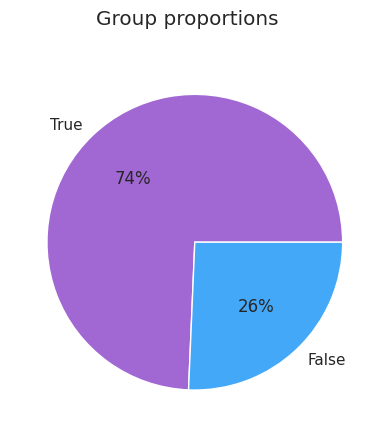

In [5]:
from holisticai.bias.plots import group_pie_plot

group_pie_plot(p_attr)

This graph show us that the proportion of non protected examples is very high compared to the protected group.


In [6]:
print ('Number of Unique Users : ' + str(df_pivot.shape[0]))
print ('Number of Unique Artists : ' + str(df_pivot.shape[1]))

Number of Unique Users : 15000
Number of Unique Artists : 1004


## **3. Model training**

### **Training the baseline**
There are many ways to recommend artists to users. We will use item based collaborative filtering since it is the simplest and most intuitive approach. For each artist, we work out a list of most similar artists. Then we recommend artists to users by looking at which artists they like, and choosing the most similar ones.

To do that, first we will define some util functions that will help us to sort these recommendations:

In [7]:
def items_liked_by_user(data_matrix, u):
    return np.nonzero(data_matrix[u])[0]

def recommended_items(data_matrix, similarity_matrix, u, k):
    liked = items_liked_by_user(data_matrix, u)
    arr = np.sum(similarity_matrix[liked,:], axis=0)
    arr[liked] = 0
    return np.argsort(arr)[-k:]

def explode(arr, num_items):
    out = np.zeros(num_items)
    out[arr] = 1
    return out

Now, we have to prepare our pivoted table to calculate the correlations and perform the filtering to create a new pivoted table where we can extract the recommendations for the users

In [8]:
from sklearn.metrics.pairwise import linear_kernel

data_matrix = df_pivot.fillna(0).to_numpy()
cosine_sim = linear_kernel(data_matrix.T, data_matrix.T)

new_recs = [explode(recommended_items(data_matrix, cosine_sim, u, 10), len(df_pivot.columns)) for u in range(df_pivot.shape[0])]
new_df_pivot = pd.DataFrame(new_recs, columns = df_pivot.columns)
new_df_pivot.head()

artist,...and you will know us by the trail of dead,2pac,3 doors down,30 seconds to mars,311,36 crazyfists,44,50 cent,65daysofstatic,Edith piaf,...,weezer,wilco,within temptation,wolfgang amadeus mozart,wu-tang clan,yann tiersen,yeah yeah yeahs,yellowcard,yo la tengo,zero 7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, we obtain our recommendation matrix:

In [9]:
mat = new_df_pivot.replace(0,np.nan)

## **4. Bias measuring**

With the new recommendation matrix at hand we will now show how we can calculate various metrics of fairness for recommender systems. In this example, we will cover item based metrics by using the `recommender_bias_metrics` function:


In [10]:
from holisticai.bias.metrics import recommender_bias_metrics

In [11]:
df = recommender_bias_metrics(mat_pred=mat, metric_type='item_based')
df_baseline=df.copy()
df_baseline

,Value,Reference
Metric,,
Aggregate Diversity,0.416335,1
GINI index,0.963811,0
Exposure Distribution Entropy,3.830850,-
Average Recommendation Popularity,5609.423227,-


Above we have batch plotted all `item_based` metrics for recommender bias task. For instance observe the Average Recommendation Popularity is 5738, meaning that on average a user will be recommended an artist that has 5738 total interactions.

An interesting feature of this function is that not only returns the calculated metrics from the predictions but also returns the reference to compare the values with an ideal fair model. This feature helps us to analyse the fairness of the predictions for the protected groups in terms of different metrics.

For example:

*   **Aggregate Diversity:** Given a matrix of scores, this function computes the recommended items for each user and returning the proportion of recommended items out of all possible items. A value of 1 is desired. We wish for a high proportion of items to be shown to avoid the "rich get richer effect".
*   **GINI index:** Measures the inequality across the frequency distribution of the recommended items. An algorithm that recommends each item the same number of times (uniform distribution) will have a Gini index of 0 and the one with extreme inequality will have a Gini of 1.

Besides these metrics, we can calculate another ones, you will find them in the documentation of the library [here](https://holisticai.readthedocs.io/en/latest/metrics.html#recommender).

## **5. Bias mitigation**

### **Inprocessing: Debiasing learning method**

Now that we could observe that the model metrics are far away from the desired values, we need to apply some kind of strategy to mitigate the bias present in the model.

Exists different kinds of strategies, and the literature has divided them into three categories: "Pre-processing", "in-processing" and "post-processing" methods. The `holisticai` library possesses different algorithms from these categories for bias mitigation. An interesting feature is that all of them are compatible with the `Scikit-learn` package, so that, if you are familiar with this package, you will not have problems using the library.

For this opportunity, we will implement the "Debiasing learning" method which is an inprocessing algorithm that handles selection biases by adapting models and estimation techniques from causal inference leading to unbiased performance estimator.

In [12]:
from holisticai.bias.mitigation import DebiasingLearningMF

To perform the mitigation with this method we will use the data matrix calculated before with the protected groups

In [13]:
mf = DebiasingLearningMF(K=40, normalization='Vanilla', lamda=0.08, metric='mse', bias_mode='Regularized', seed=1)
mf.fit(data_matrix)

In [14]:
def recommended_items(model, data_matrix, k):
    recommended_items_mask = data_matrix>0
    candidate_index = ~recommended_items_mask
    candidate_rating = model.pred*candidate_index
    return np.argsort(-candidate_rating,axis=1)[:,:k]

In [15]:
new_items = recommended_items(mf, data_matrix, 10)
new_recs = [explode(new_items[u], len(df_pivot.columns)) for u in range(df_pivot.shape[0])]
new_df_pivot_db = pd.DataFrame(new_recs, columns = df_pivot.columns)

mat = new_df_pivot_db.replace(0,np.nan).to_numpy()

df = recommender_bias_metrics(mat_pred=mat, metric_type='item_based')
df_debl =df.copy()
df_debl

,Value,Reference
Metric,,
Aggregate Diversity,0.430279,1
GINI index,0.845359,0
Exposure Distribution Entropy,5.341987,-
Average Recommendation Popularity,897.859973,-


We can observe that the use of the mitigator improves the "Aggregate diversity", reaching the reference value, as well as the remain values showing a clearly improvement. Let's compare them with our baseline.

### Comparing results

Now that we could observe how is the implementation of the mitigator in the model, we will compare the results between the baseline and the implementations with the mitigator to analyse how the metrics have changed.

In [16]:
result = pd.concat([df_baseline, df_debl], axis=1).iloc[:, [0,2,1]]
result.columns = ['Baseline','Mitigator', 'Reference']
result

,Baseline,Mitigator,Reference
Metric,,,
Aggregate Diversity,0.416335,0.430279,1
GINI index,0.963811,0.845359,0
Exposure Distribution Entropy,3.830850,5.341987,-
Average Recommendation Popularity,5609.423227,897.859973,-


From the previous chart, we can see that although some of the actual metrics are still far from the ideal values, an improvement is obtained by applying this method in the data, compared with our baseline. 

Notice that we can analyse how these values are affected by varying the hyperparameters of the method.

For example, this method allows us to set different hyperparameters, for instance the number of dimensions `k`, the normalization strategy,  the metric used as cost function and some extra parameters such as a model parameter (`lambda`), the propensity clip value and the bias value used by the model.

Let's try by varying the number of dimensions `k` of the method to observe how the metrics are affected:

In [ ]:
def calculate_metrics(data_matrix, p_attr, k, metrics_cols):
  mf = DebiasingLearningMF(K=k, normalization="Vanilla", lamda=0.01, metric='mse', bias_mode='Free', seed=1)
  mf.fit(data_matrix)

  new_items = recommended_items(mf, data_matrix, 10)
  new_recs = [explode(new_items[u], len(df_pivot.columns)) for u in range(df_pivot.shape[0])]
  new_df_pivot_db = pd.DataFrame(new_recs, columns = df_pivot.columns)

  mat = new_df_pivot_db.replace(0,np.nan).to_numpy()

  df = recommender_bias_metrics(mat_pred=mat, metric_type='item_based')

  # Calculate metrics
  metrics = [
      k, 
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics

In [ ]:
metrics_val = []
metrics_cols = ["Aggregate Diversity", "GINI index", "Exposure Distribution Entropy", "Average Recommendation Popularity"]

for k in np.linspace(10,100,4):
  metrics_val.append(calculate_metrics(data_matrix, p_attr, int(k), metrics_cols))

metrics = ['k']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

/usr/local/lib/python3.9/dist-packages/holisticai/utils/_recommender_tools.py:228: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.where(p != 0, p * np.log(p), 0))
/usr/local/lib/python3.9/dist-packages/holisticai/utils/_recommender_tools.py:228: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(np.where(p != 0, p * np.log(p), 0))
/usr/local/lib/python3.9/dist-packages/holisticai/utils/_recommender_tools.py:228: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.where(p != 0, p * np.log(p), 0))
/usr/local/lib/python3.9/dist-packages/holisticai/utils/_recommender_tools.py:228: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(np.where(p != 0, p * np.log(p), 0))
/usr/local/lib/python3.9/dist-packages/holisticai/utils/_recommender_tools.py:228: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.where(p != 0, p * np.log(p), 0))
/usr/local/lib/python3.9/dist-packages/holisticai/utils/_recom

,k,Aggregate Diversity,GINI index,Exposure Distribution Entropy,Average Recommendation Popularity
0,10,0.237052,0.911978,4.771213,1542.858480
1,40,0.442231,0.842703,5.358370,878.011867
2,70,0.566733,0.787687,5.654090,652.587520
3,100,0.699203,0.741819,5.851413,537.838947


Text(0.5, 0, 'Dimensions')

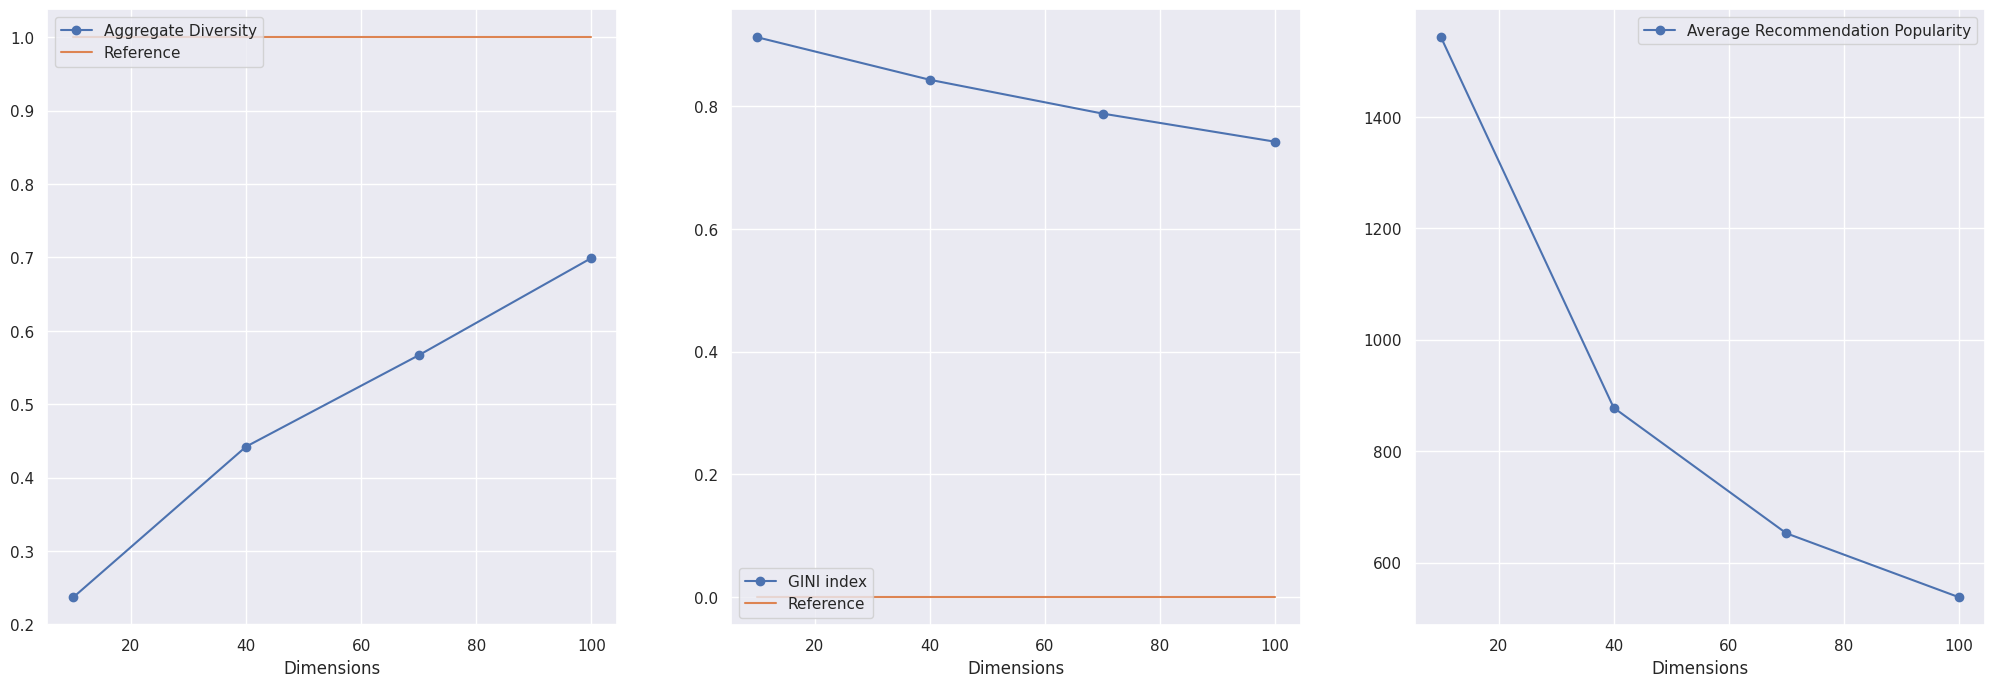

In [ ]:
x_axis = df_metrics.k
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(x_axis, df_metrics['Aggregate Diversity'], 'o-', label='Aggregate Diversity')
plt.plot(x_axis, np.ones_like(df_metrics['k']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('Dimensions')
plt.subplot(132)
plt.plot(x_axis, df_metrics['GINI index'], 'o-', label='GINI index')
plt.plot(x_axis, np.zeros_like(df_metrics['k']), label='Reference')
plt.legend(loc='lower left')
plt.xlabel('Dimensions')
plt.subplot(133)
plt.plot(x_axis, df_metrics['Average Recommendation Popularity'], 'o-', label='Average Recommendation Popularity')
plt.legend(loc='upper right')
plt.xlabel('Dimensions')

As we can see, as the number of dimensions `k` increases, we get a better model in terms of fairness. In general, we can observe that the use of the mitigator improves the metrics showing a clearly improvement.

#Summary

Through this tutorial we could present to the user how the `holisticai` library can be easily used to measure the bias present in recommender systems by the application of the `recommender_bias_metrics` function, which returns the calculated values for different metrics as well as the reference values respectively.

In addition, we shown how to mitigate the bias by applying some methods, for this opportunity we applied the "Debiasing learning" technique to increase the fairness of the recommender system, this is an in-processing method that leads to unbiased performance estimators substantially improving prediction performance. Consequently we could observe how the metrics are influenced by varing the number of dimensions `k` of the model, and showing that this method increases the fairness of the model.